# Music genre prediction

## Вводная информация

### Описание задачи

Вы сотрудник Отдела Data Science популярного музыкального стримингового сервиса "МиФаСоль". Сервис расширяет работу с новыми артистами и музыкантами, в связи с чем возникла задача -- правильно классифицировать новые музыкальные треки, чтобы улучшить работу рекомендательной системы. Ваши коллеги из отдела работы со звуком подготовили датасет, в котором собраны некоторые характеристики музыкальных произведений и их жанры. Ваша задача -- разработать модель, позволяющую классифицировать музыкальные произведения по жанрам.

### Этапы работы

* загрузка и ознакомление с данными,
* предварительная обработка,
* полноценный разведочный анализ,
* разработка новых синтетических признаков,
* проверка на мультиколлинеарность,
* отбор финального набора обучающих признаков,
* выбор и обучение моделей,
* итоговая оценка качества предсказания лучшей модели,
* анализ важности ее признаков.

### Данные

* train.csv - информация (~20000) музыкальных треках, которые будут использоваться в качестве обучающих данных.
* test.csv - информация (~5000) музыкальных треках, которые будут использоваться в качестве тестовых данных. Ваша задача - предсказать значение * 'music_genre' для каждого трека из этого датасета.
* sample_submit.csv - файл предсказаний в правильном формате.
* instance_id - идентификатор трека в тестовом наборе.
* music_genre - Целевой признак. Для каждого трека предскажите категориальное значение соответствующее музыкальному жанру трека.

### Описание полей данных

* instance_id - уникальный идентификатор трека
* track_name - название трека
* acousticness - акустичность 
* danceability - танцевальность
* duration_ms -продолжительность в милисекундах
* energy - энергичность
* instrumentalness - инструментальность
* key - тональность
* liveness - привлекательность
* loudness - громкость
* mode - наклонение
* speechiness - выразительность
* tempo - темп
* obtained_date - дата загрузки в сервис
* valence - привлекательность произведения для пользователей сервиса
* music_genre - музыкальный жанр

## Предподготовка данных

### Загрузка и изучение данных

In [168]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import phik
from phik.report import plot_correlation_matrix
from phik import report
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix, f1_score, precision_recall_curve,
                             precision_score, recall_score, roc_auc_score,
                             roc_curve, accuracy_score, classification_report)
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV, train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder, MinMaxScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import set_config
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import RobustScaler

from catboost import CatBoostClassifier
from sklearn.utils import resample, shuffle
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import RandomizedSearchCV

In [169]:
train = pd.read_csv('kaggle_music_genre_train.csv')

In [170]:
train.head()

,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,25143.0,Highwayman,0.4800,0.670,182653.0,0.351,0.017600,D,0.115,-16.842,Major,0.0463,101.384,4-Apr,0.450,Country
1,26091.0,Toes Across The Floor,0.2430,0.452,187133.0,0.670,0.000051,A,0.108,-8.392,Minor,0.0352,113.071,4-Apr,0.539,Rock
2,87888.0,First Person on Earth,0.2280,0.454,173448.0,0.804,0.000000,E,0.181,-5.225,Minor,0.3710,80.980,4-Apr,0.344,Alternative
3,77021.0,No Te Veo - Digital Single,0.0558,0.847,255987.0,0.873,0.000003,G#,0.325,-4.805,Minor,0.0804,116.007,4-Apr,0.966,Hip-Hop
4,20852.0,Chasing Shadows,0.2270,0.742,195333.0,0.575,0.000002,C,0.176,-5.550,Major,0.0487,76.494,4-Apr,0.583,Alternative


In [171]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20394 entries, 0 to 20393
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       20394 non-null  float64
 1   track_name        20394 non-null  object 
 2   acousticness      20394 non-null  float64
 3   danceability      20394 non-null  float64
 4   duration_ms       20394 non-null  float64
 5   energy            20394 non-null  float64
 6   instrumentalness  20394 non-null  float64
 7   key               19659 non-null  object 
 8   liveness          20394 non-null  float64
 9   loudness          20394 non-null  float64
 10  mode              19888 non-null  object 
 11  speechiness       20394 non-null  float64
 12  tempo             19952 non-null  float64
 13  obtained_date     20394 non-null  object 
 14  valence           20394 non-null  float64
 15  music_genre       20394 non-null  object 
dtypes: float64(11), object(5)
memory usage: 

In [172]:
train.isna().sum()

instance_id           0
track_name            0
acousticness          0
danceability          0
duration_ms           0
energy                0
instrumentalness      0
key                 735
liveness              0
loudness              0
mode                506
speechiness           0
tempo               442
obtained_date         0
valence               0
music_genre           0
dtype: int64

### Работа с пропусками и дубликатами

In [173]:
'''train = train.dropna(subset=['key'])
train = train.dropna(subset=['mode'])
train = train.dropna(subset=['tempo'])'''

"train = train.dropna(subset=['key'])\ntrain = train.dropna(subset=['mode'])\ntrain = train.dropna(subset=['tempo'])"

In [174]:
'''train['key'] = train['key'].fillna('unknown')
train['mode'] = train['mode'].fillna('unknown')
train['tempo'] = train['tempo'].fillna(0)'''

"train['key'] = train['key'].fillna('unknown')\ntrain['mode'] = train['mode'].fillna('unknown')\ntrain['tempo'] = train['tempo'].fillna(0)"

In [175]:
print(train.isna().sum())

instance_id           0
track_name            0
acousticness          0
danceability          0
duration_ms           0
energy                0
instrumentalness      0
key                 735
liveness              0
loudness              0
mode                506
speechiness           0
tempo               442
obtained_date         0
valence               0
music_genre           0
dtype: int64


In [176]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
instance_id,20394.0,55973.846916,20695.792545,20011.00000,38157.25000,56030.000000,73912.750000,91758.000
acousticness,20394.0,0.274783,0.321643,0.00000,0.01520,0.120000,0.470000,0.996
danceability,20394.0,0.561983,0.171898,0.06000,0.45100,0.570000,0.683000,0.978
duration_ms,20394.0,220375.425272,126728.326142,-1.00000,177517.00000,219533.000000,266000.000000,4497994.000
energy,20394.0,0.625276,0.251238,0.00101,0.47000,0.666000,0.830000,0.999
instrumentalness,20394.0,0.159989,0.306503,0.00000,0.00000,0.000144,0.084475,0.996
liveness,20394.0,0.198540,0.166742,0.01360,0.09730,0.130000,0.253000,1.000
loudness,20394.0,-8.552998,5.499917,-44.40600,-10.25575,-7.052000,-5.054000,3.744
speechiness,20394.0,0.091352,0.097735,0.02230,0.03560,0.049050,0.095575,0.942
tempo,19952.0,120.942522,30.427590,34.76500,95.92175,120.012500,141.966250,220.041


In [177]:
# удалим строки где переменная 'duration_ms' имеет значение 0 и меньше
'''train = train[train['duration_ms'] > 0]
train = train[train['duration_ms'] < 2_000_000]'''

"train = train[train['duration_ms'] > 0]\ntrain = train[train['duration_ms'] < 2_000_000]"

In [178]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
instance_id,20394.0,55973.846916,20695.792545,20011.00000,38157.25000,56030.000000,73912.750000,91758.000
acousticness,20394.0,0.274783,0.321643,0.00000,0.01520,0.120000,0.470000,0.996
danceability,20394.0,0.561983,0.171898,0.06000,0.45100,0.570000,0.683000,0.978
duration_ms,20394.0,220375.425272,126728.326142,-1.00000,177517.00000,219533.000000,266000.000000,4497994.000
energy,20394.0,0.625276,0.251238,0.00101,0.47000,0.666000,0.830000,0.999
instrumentalness,20394.0,0.159989,0.306503,0.00000,0.00000,0.000144,0.084475,0.996
liveness,20394.0,0.198540,0.166742,0.01360,0.09730,0.130000,0.253000,1.000
loudness,20394.0,-8.552998,5.499917,-44.40600,-10.25575,-7.052000,-5.054000,3.744
speechiness,20394.0,0.091352,0.097735,0.02230,0.03560,0.049050,0.095575,0.942
tempo,19952.0,120.942522,30.427590,34.76500,95.92175,120.012500,141.966250,220.041


In [179]:
train = train.drop(['instance_id', 'track_name', 'obtained_date'], axis=1)

In [180]:
# проверим есть ли дубликаты в тренировочном и тестовом датасетах
train.duplicated().sum()

7

In [181]:
train = train.drop_duplicates()

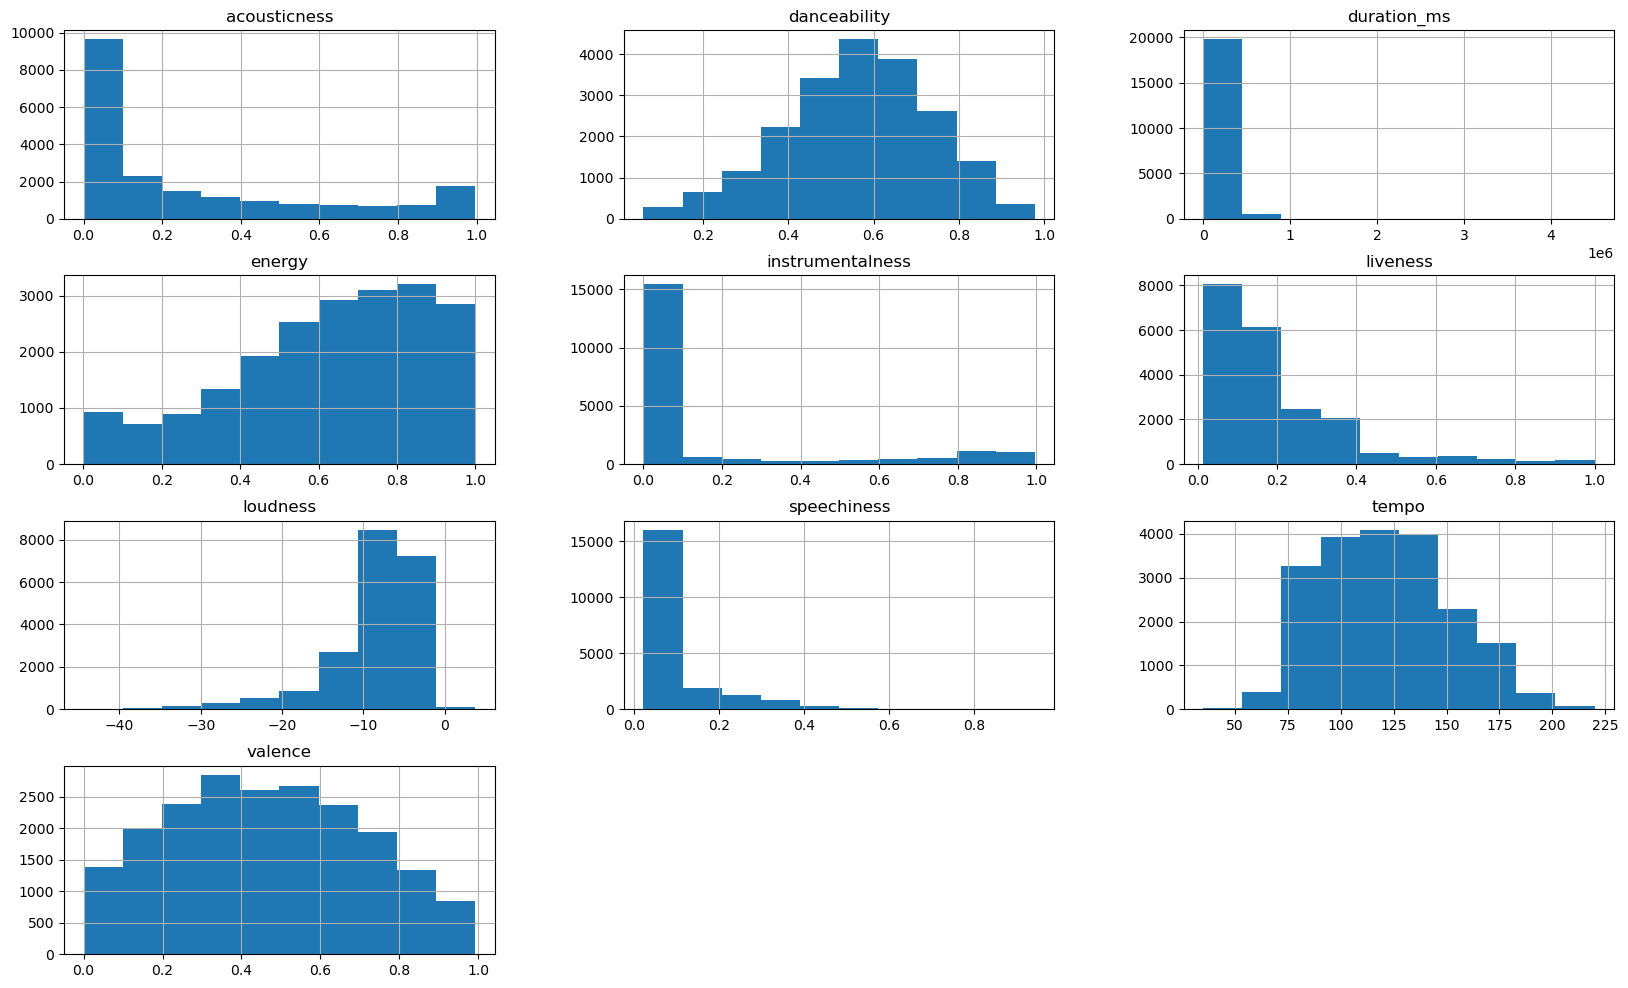

In [182]:
# построим гистограммы распределения тренировочного датасета
train.hist(figsize=(20, 12));

In [183]:
phik_overview = train.phik_matrix() # type: ignore

interval columns not set, guessing: ['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']


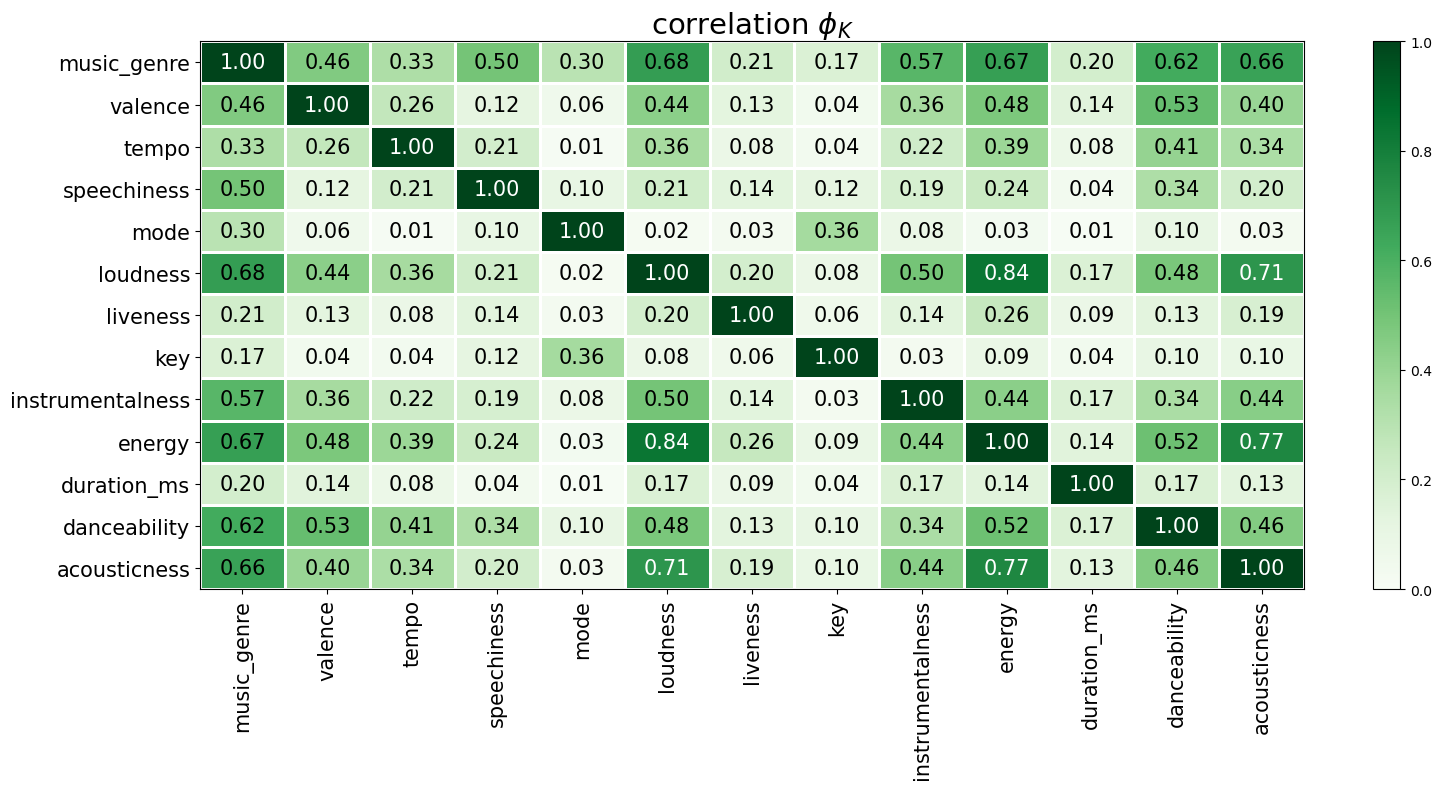

In [184]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(16, 8))
plt.tight_layout()

In [185]:
significance_overview = train.significance_matrix() # type: ignore

interval columns not set, guessing: ['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']


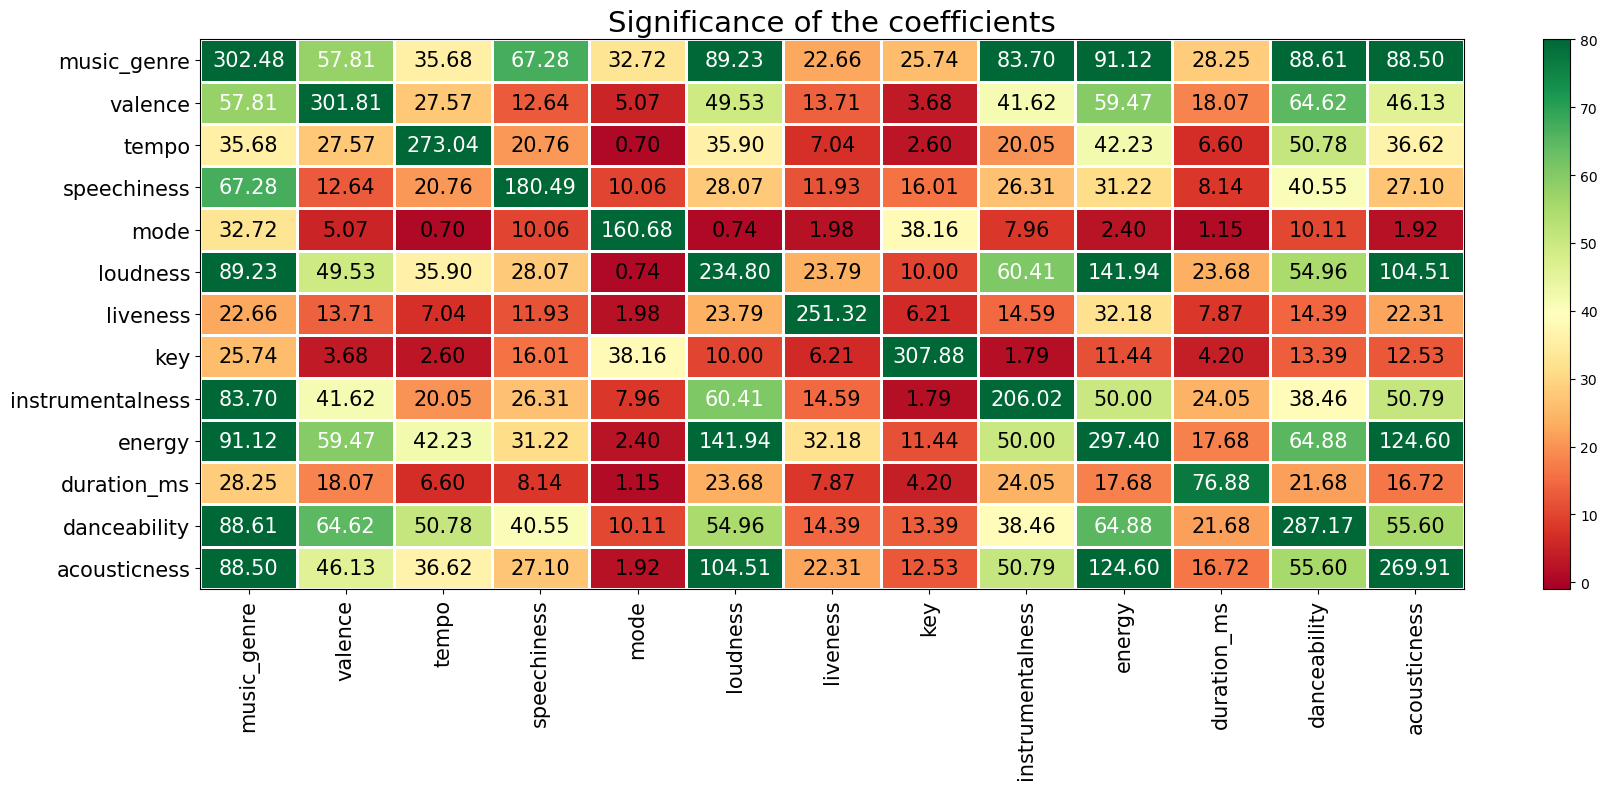

In [186]:
plot_correlation_matrix(significance_overview.fillna(0).values, 
                        x_labels=significance_overview.columns, 
                        y_labels=significance_overview.index, 
                        vmin=-1, vmax=80, title="Significance of the coefficients", 
                        usetex=False, fontsize_factor=1.5, figsize=(18, 8))
plt.tight_layout()

In [187]:
global_correlation, global_labels = train.global_phik() # type: ignore

interval columns not set, guessing: ['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']


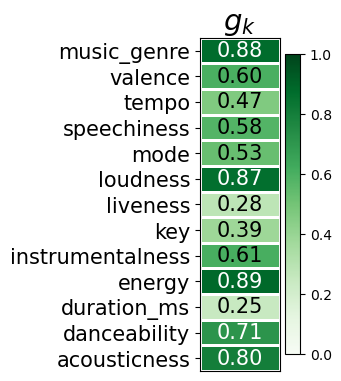

In [188]:
plot_correlation_matrix(global_correlation, 
                        x_labels=[''], y_labels=global_labels, 
                        vmin=0, vmax=1, figsize=(3.5,4),
                        color_map="Greens", title=r"$g_k$",
                        fontsize_factor=1.5)
plt.tight_layout()

In [189]:
vif_train = train
vif_train['key'] = vif_train['key'].fillna('unknown')
vif_train['mode'] = vif_train['mode'].fillna('unknown')
vif_train['tempo'] = vif_train['tempo'].fillna(0)
numeric_data = vif_train[['duration_ms', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']]

vif_data = pd.DataFrame()
vif_data['Feature'] = numeric_data.columns
vif_data['VIF'] = [variance_inflation_factor(numeric_data.values, i) for i in range(numeric_data.shape[1])]

print(vif_data)

            Feature        VIF
0       duration_ms   4.031712
1      acousticness   3.779925
2      danceability  11.626567
3            energy  14.586697
4  instrumentalness   1.776855
5          liveness   2.564730
6          loudness   7.833807
7       speechiness   2.119975
8             tempo  11.457892
9           valence   6.448995


In [190]:
'''train['combined_feature'] = (train['energy'] + train['tempo'] + train['danceability']) / 3
train = train.drop(['energy', 'tempo', 'danceability'], axis=1)'''

"train['combined_feature'] = (train['energy'] + train['tempo'] + train['danceability']) / 3\ntrain = train.drop(['energy', 'tempo', 'danceability'], axis=1)"

In [191]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20387 entries, 0 to 20393
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   acousticness      20387 non-null  float64
 1   danceability      20387 non-null  float64
 2   duration_ms       20387 non-null  float64
 3   energy            20387 non-null  float64
 4   instrumentalness  20387 non-null  float64
 5   key               20387 non-null  object 
 6   liveness          20387 non-null  float64
 7   loudness          20387 non-null  float64
 8   mode              20387 non-null  object 
 9   speechiness       20387 non-null  float64
 10  tempo             20387 non-null  float64
 11  valence           20387 non-null  float64
 12  music_genre       20387 non-null  object 
dtypes: float64(10), object(3)
memory usage: 2.2+ MB


In [192]:
train['key'].value_counts() 

G          2303
C          2149
C#         2125
D          2109
A          2013
F          1615
B          1521
E          1516
G#         1267
A#         1223
F#         1206
unknown     734
D#          606
Name: key, dtype: int64

In [193]:
train['mode'].value_counts() 

Major      12826
Minor       7055
unknown      506
Name: mode, dtype: int64

In [194]:
train['music_genre'].value_counts() 

Blues          2857
Alternative    2601
Electronic     2559
Rap            2427
Rock           2165
Country        2120
Anime          1901
Classical      1373
Jazz           1239
Hip-Hop        1145
Name: music_genre, dtype: int64

## Подготовка данных к обучению моделей

### Тестируем pipeline

In [229]:
num_cols = ['duration_ms', 'acousticness', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'danceability', 'valence', 'tempo', 'energy']
cat_cols = ['key', 'mode']

In [230]:
X = train[num_cols+cat_cols]
y = train['music_genre']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [231]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((16309, 12), (4078, 12), (16309,), (4078,))

In [232]:
num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='constant', fill_value=0)),
    ('scale', RobustScaler())
])
cat_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('one-hot',OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

In [233]:
col_trans = ColumnTransformer(transformers=[
    ('num_pipeline',num_pipeline,num_cols),
    ('cat_pipeline',cat_pipeline,cat_cols)
    ],
    remainder='drop',
    n_jobs=-1)

### GridSearchCV

In [240]:
'''%%time
clf = LogisticRegression()

clf_pipeline = Pipeline(steps=[
('col_trans', col_trans),
('model', clf)
])

param_dist = {
    'model__C': np.logspace(-3, 3, 7),  # Логарифмический диапазон для параметра C
    'model__penalty': ['l1', 'l2'],  # Регуляризация l1 или l2
    'model__solver': ['liblinear', 'saga']  # Различные методы оптимизации для l1 регуляризации
}

grid_pipeline = RandomizedSearchCV(clf_pipeline, param_distributions=param_dist, n_iter=10, scoring='f1_weighted', cv=5, verbose=1, n_jobs=-1)

grid_pipeline.fit(X_train, y_train)

preds = grid_pipeline.predict(X_test)
f1 = f1_score(y_test, preds, average='weighted')

print(f"F1 score: {f1}")
print("Best parameters:", grid_pipeline.best_params_)
print("Best score:", grid_pipeline.best_score_)'''

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/sergejvorobev/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/sergejvorobev/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/sergejvorobev/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/sergejvorobev/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was re

F1 score: 0.3780015133338941
Best parameters: {'model__solver': 'saga', 'model__penalty': 'l1', 'model__C': 1.0}
Best score: 0.3695392857742339
CPU times: user 3.45 s, sys: 110 ms, total: 3.56 s
Wall time: 47.2 s


/Users/sergejvorobev/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [205]:
"""%%time

clf = SVC()

clf_pipeline = Pipeline(steps=[
('col_trans', col_trans),
('model', clf)
])

parameters = {'model__C': [0.1, 1, 10],
'model__kernel': ['linear', 'rbf', 'poly']}

grid_pipeline = GridSearchCV(clf_pipeline, parameters)

grid_pipeline.fit(X_train, y_train)

# Получение предсказаний на тестовом наборе данных
y_pred = grid_pipeline.predict(X_test)

# Вычисление F1-меры
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"F1 score: {f1}")

# Вывод наилучших параметров и оценки
print("Best parameters:", grid_pipeline.best_params_)
print("Best score:", grid_pipeline.best_score_)"""

'%%time\n\nclf = SVC()\n\nclf_pipeline = Pipeline(steps=[\n(\'col_trans\', col_trans),\n(\'model\', clf)\n])\n\nparameters = {\'model__C\': [0.1, 1, 10],\n\'model__kernel\': [\'linear\', \'rbf\', \'poly\']}\n\ngrid_pipeline = GridSearchCV(clf_pipeline, parameters)\n\ngrid_pipeline.fit(X_train, y_train)\n\n# Получение предсказаний на тестовом наборе данных\ny_pred = grid_pipeline.predict(X_test)\n\n# Вычисление F1-меры\nf1 = f1_score(y_test, y_pred, average=\'weighted\')\n\nprint(f"F1 score: {f1}")\n\n# Вывод наилучших параметров и оценки\nprint("Best parameters:", grid_pipeline.best_params_)\nprint("Best score:", grid_pipeline.best_score_)'

In [241]:
"""%%time

clf = RandomForestClassifier()

clf_pipeline = Pipeline(steps=[
('col_trans', col_trans),
('model', clf)
])

parameters = {'model__n_estimators': [100, 200, 300],
'model__max_depth': [None, 5, 10]}

grid_pipeline = GridSearchCV(clf_pipeline, parameters)

grid_pipeline.fit(X_train, y_train)
y_pred = grid_pipeline.predict(X_test)

f1 = f1_score(y_test, y_pred, average='weighted')

print(f"F1 score: {f1}")
print("Best parameters:", grid_pipeline.best_params_)
print("Best score:", grid_pipeline.best_score_)"""

/Users/sergejvorobev/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/sergejvorobev/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/sergejvorobev/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/sergejvorobev/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was re

F1 score: 0.41070176796054286
Best parameters: {'model__max_depth': 10, 'model__n_estimators': 100}
Best score: 0.46164631485453844
CPU times: user 36 s, sys: 1.14 s, total: 37.2 s
Wall time: 42.5 s


In [242]:
'''%%time

clf = GradientBoostingClassifier()

clf_pipeline = Pipeline(steps=[
('col_trans', col_trans),
('model', clf)
])

parameters = {'model__n_estimators': [100],
'model__max_depth': [3, 5],
'model__learning_rate': [0.1, 0.01]}

grid_pipeline = GridSearchCV(clf_pipeline, parameters)

grid_pipeline.fit(X_train, y_train)
y_pred = grid_pipeline.predict(X_test)

f1 = f1_score(y_test, y_pred, average='weighted')

print(f"F1 score: {f1}")
print("Best parameters:", grid_pipeline.best_params_)
print("Best score:", grid_pipeline.best_score_)'''

/Users/sergejvorobev/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/sergejvorobev/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/sergejvorobev/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/sergejvorobev/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was re

F1 score: 0.43753762573443505
Best parameters: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 100}
Best score: 0.46238249223352135
CPU times: user 16min 58s, sys: 17.8 s, total: 17min 15s
Wall time: 19min 7s


In [208]:
"""%%time

clf = MLPClassifier()

clf_pipeline = Pipeline(steps=[
('col_trans', col_trans),
('model', clf)
])

parameters = {'model__hidden_layer_sizes': [(100,), (200,), (300,)],
'model__activation': ['relu', 'tanh', 'logistic'],
'model__alpha': [0.0001, 0.001, 0.01]}

grid_pipeline = GridSearchCV(clf_pipeline, parameters)

grid_pipeline.fit(X_train, y_train)
y_pred = grid_pipeline.predict(X_test)

f1 = f1_score(y_test, y_pred, average='weighted')

print(f"F1 score: {f1}")
print("Best parameters:", grid_pipeline.best_params_)
print("Best score:", grid_pipeline.best_score_)"""

'%%time\n\nclf = MLPClassifier()\n\nclf_pipeline = Pipeline(steps=[\n(\'col_trans\', col_trans),\n(\'model\', clf)\n])\n\nparameters = {\'model__hidden_layer_sizes\': [(100,), (200,), (300,)],\n\'model__activation\': [\'relu\', \'tanh\', \'logistic\'],\n\'model__alpha\': [0.0001, 0.001, 0.01]}\n\ngrid_pipeline = GridSearchCV(clf_pipeline, parameters)\n\ngrid_pipeline.fit(X_train, y_train)\ny_pred = grid_pipeline.predict(X_test)\n\nf1 = f1_score(y_test, y_pred, average=\'weighted\')\n\nprint(f"F1 score: {f1}")\nprint("Best parameters:", grid_pipeline.best_params_)\nprint("Best score:", grid_pipeline.best_score_)'

### PipeLine

In [225]:
clf = CatBoostClassifier(depth=4, l2_leaf_reg=3, learning_rate=0.1)
clf_pipeline = Pipeline(steps=[
    ('col_trans', col_trans),
    ('model', clf)
])

clf_pipeline.fit(X_train, y_train)
y_pred = clf_pipeline.predict(X_test)

print('f1 =', f1_score(y_test, y_pred, average='weighted'))

set_config(display='diagram')
display(clf_pipeline)

/Users/sergejvorobev/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


0:	learn: 2.2048425	total: 30.4ms	remaining: 30.4s
1:	learn: 2.1322531	total: 66.4ms	remaining: 33.1s
2:	learn: 2.0697047	total: 78.8ms	remaining: 26.2s
3:	learn: 2.0196483	total: 93.2ms	remaining: 23.2s
4:	learn: 1.9798171	total: 104ms	remaining: 20.7s
5:	learn: 1.9448398	total: 116ms	remaining: 19.3s
6:	learn: 1.9149105	total: 125ms	remaining: 17.8s
7:	learn: 1.8844846	total: 139ms	remaining: 17.2s
8:	learn: 1.8597158	total: 151ms	remaining: 16.6s
9:	learn: 1.8374601	total: 161ms	remaining: 16s
10:	learn: 1.8160749	total: 171ms	remaining: 15.4s
11:	learn: 1.7971695	total: 182ms	remaining: 15s
12:	learn: 1.7773962	total: 192ms	remaining: 14.6s
13:	learn: 1.7620018	total: 203ms	remaining: 14.3s
14:	learn: 1.7454614	total: 214ms	remaining: 14s
15:	learn: 1.7307077	total: 223ms	remaining: 13.7s
16:	learn: 1.7188430	total: 239ms	remaining: 13.8s
17:	learn: 1.7083438	total: 254ms	remaining: 13.8s
18:	learn: 1.6945330	total: 279ms	remaining: 14.4s
19:	learn: 1.6839740	total: 306ms	remaining

## Проводим финальное тестирование

In [117]:
test = pd.read_csv('kaggle_music_genre_test.csv')

In [118]:
tes1 = test

In [119]:
test = test.drop(['instance_id', 'track_name', 'obtained_date'], axis=1)

In [120]:
#test['key'] = test['key'].fillna('unknown')
#test['mode'] = test['mode'].fillna('unknown')
#test['mode'] = test['mode'].fillna(0)

In [121]:
#ohe_key = pd.get_dummies(test['key'], prefix='key', drop_first=True)
#ohe_mode = pd.get_dummies(test['mode'], prefix='mode', drop_first=True)
#test = pd.concat([test, ohe_key, ohe_mode], axis=1)
#test = test.drop(['key', 'mode'], axis=1)

In [122]:
test.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence
0,0.301000,0.757,146213.0,0.679,0.00000,A#,0.3030,-7.136,Minor,0.3560,90.361,0.895
1,0.538000,0.256,240360.0,0.523,0.00832,G#,0.0849,-5.175,Major,0.0294,78.385,0.318
2,0.005830,0.678,284000.0,0.770,0.00000,A,0.1090,-4.399,Minor,0.2220,90.000,0.412
3,0.020300,0.592,177354.0,0.749,0.00000,B,0.1220,-4.604,Major,0.0483,160.046,0.614
4,0.000335,0.421,-1.0,0.447,0.01480,D,0.0374,-8.833,Major,0.2020,73.830,0.121


In [123]:
y_pred = clf_pipeline.predict(X_test)

y_pred = y_pred.ravel().tolist()
# Создание столбца с предсказаниями
y_pred_series = pd.Series(y_pred, name='music_genre')

# Создание столбца с instance_id
instance_id_column = tes1['instance_id']

# Создание DataFrame из столбцов
submit = pd.concat([instance_id_column, y_pred_series], axis=1)

# Сохранение DataFrame с предсказаниями в файл
submit.to_csv('submit.csv', index=False)